# Sentiment Analysis: Twitter vs Amazon Review Data

This notebook compares different sentiment analysis models on Twitter and Amazon datasets.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
from copy import deepcopy
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from keras.models import Model
from sklearn.preprocessing import LabelEncoder

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Data Loading

In [2]:
amazon_data = pd.read_csv('amazon_reviews.csv')
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


In [3]:
amazon_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            4915 non-null   int64  
 1   reviewerName          4914 non-null   object 
 2   overall               4915 non-null   float64
 3   reviewText            4914 non-null   object 
 4   reviewTime            4915 non-null   object 
 5   day_diff              4915 non-null   int64  
 6   helpful_yes           4915 non-null   int64  
 7   helpful_no            4915 non-null   int64  
 8   total_vote            4915 non-null   int64  
 9   score_pos_neg_diff    4915 non-null   int64  
 10  score_average_rating  4915 non-null   float64
 11  wilson_lower_bound    4915 non-null   float64
dtypes: float64(3), int64(6), object(3)
memory usage: 460.9+ KB


In [4]:
amazon_data.duplicated().sum()

np.int64(0)

In [5]:
amazon_data.isnull().sum()

,0
Unnamed: 0,0
reviewerName,1
overall,0
reviewText,1
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


In [6]:
amazon_data.dropna(subset=['reviewerName', 'reviewText'], inplace=True)

amazon_data.drop_duplicates(subset=['reviewText'], keep='first', inplace=True)
amazon_data.reset_index(drop=True, inplace=True)

display(amazon_data.head())
print(amazon_data.shape)

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0


(4912, 12)


In [7]:
def categorize_sentiment(row):
    if row['overall'] > 3:
        return 'positive'
    elif row['overall'] < 3:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to create the 'type' column
amazon_data['type'] = amazon_data.apply(categorize_sentiment, axis=1)

# Display the first few rows to verify the new column
amazon_data.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [8]:
df = deepcopy(amazon_data)
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive


In [9]:
df['type'].value_counts()

,count
type,
positive,4446
negative,324
neutral,142


In [10]:
df.isnull().sum()

,0
Unnamed: 0,0
reviewerName,0
overall,0
reviewText,0
reviewTime,0
day_diff,0
helpful_yes,0
helpful_no,0
total_vote,0
score_pos_neg_diff,0


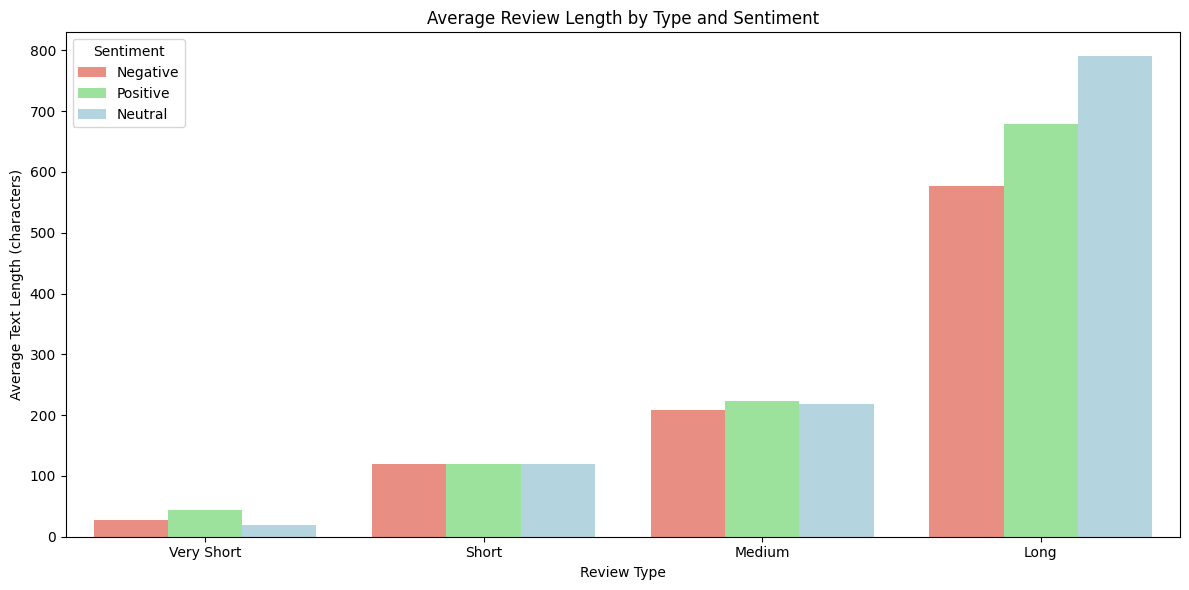

In [11]:
# Calculate text length for each review
df['text_length'] = df['reviewText'].apply(len)

# Define bins and labels for review length
bins = [0, 50, 150, 300, np.inf]
labels = ['Very Short', 'Short', 'Medium', 'Long']
df['review_type'] = pd.cut(df['text_length'], bins=bins, labels=labels)

# Ensure sentiment column exists
if 'sentiment' not in df.columns:
    df['sentiment'] = (df['overall'] > 3).astype(int)

# Create a grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='review_type', y='text_length', hue='type',
           data=df, palette=['salmon', 'lightgreen', 'lightblue'],
           ci=None)  # No confidence intervals

plt.title('Average Review Length by Type and Sentiment')
plt.xlabel('Review Type')
plt.ylabel('Average Text Length (characters)')
plt.legend(title='Sentiment', labels=['Negative', 'Positive', 'Neutral'])
plt.tight_layout()
plt.show()

In [12]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Fill NaNs with empty string
df['reviewText'] = df['reviewText'].fillna('')

df['lower'] = df['reviewText'].str.lower()
df['lower'] = df['lower'].apply(lambda x: re.sub(r'[^\w\s]', '', x))
df['lower'] = df['lower'].apply(lambda x: re.sub(r'\d+', '', x))
df['lower'] = [str(i).strip() for i in df['lower']]

# Define function to remove punctuation, numbers, stopwords, then tokenize, stem, and lemmatize in lower column
def preprocess_text(text):
    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in (stop_words)])

    # Tokenization
    text = word_tokenize(text)

    # Stemming
    stemmer = nltk.PorterStemmer()
    text = [stemmer.stem(y) for y in text]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(y) for y in text]

    return text

df['lower'] = df['lower'].apply(preprocess_text)
df.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,type,text_length,review_type,sentiment,lower
0,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,positive,158,Medium,1,"[purchas, devic, work, advertis, never, much, ..."
1,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,positive,166,Medium,1,"[work, expect, sprung, higher, capac, think, m..."
2,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,positive,340,Long,1,"[think, work, greathad, diff, bran, gb, card, ..."
3,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,positive,290,Medium,1,"[bought, retail, packag, arriv, legit, orang, ..."
4,5,2Cents!,5.0,It's mini storage. It doesn't do anything els...,2013-04-29,588,0,0,0,0,0.0,0.0,positive,282,Medium,1,"[mini, storag, doesnt, anyth, el, suppos, purc..."


In [13]:
# Perform Word Embedding using CountVectorizer
cv = CountVectorizer(max_features=5000)
X = cv.fit_transform(df['lower'].apply(lambda x: ' '.join(x))).toarray()
# Use the multi-class 'type' column instead of 'sentiment'
y = df['type']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,
                                                    stratify=y, shuffle=True)

# Define a function to train and evaluate the model
def train_evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    auc_roc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), multi_class='ovo')

    return accuracy, precision, recall, f1, auc_roc, y_pred

# Initialize Logistic Regression model
lr = LogisticRegression(max_iter=1000)

# Train and evaluate the model
lr_accuracy, lr_precision, lr_recall, lr_f1, lr_auc_roc, y_pred = train_evaluate_model(lr, X_train, y_train, X_test, y_test)

# Define the label order
labels_order = ['positive', 'neutral', 'negative']


# Display the evaluation metrics
print('Logistic Regression Model')
print('-------------------------')
print('Accuracy:', lr_accuracy)
print('Precision:', lr_precision)
print('Recall:', lr_recall)
print('F1 Score:', lr_f1)
print('AUC-ROC:', lr_auc_roc)

Logistic Regression Model
-------------------------
Accuracy: 0.9267548321464903
Precision: 0.5577107279693486
Recall: 0.5075770671276288
F1 Score: 0.5277217987285454
AUC-ROC: 0.6570167255768566


<Figure size 800x600 with 0 Axes>

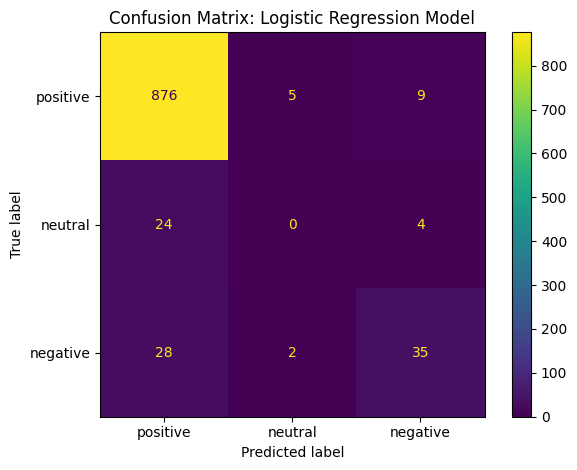

In [14]:
# Compute and display the confusion matrix
cm_multi = confusion_matrix(y_test, y_pred, labels=labels_order)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_multi, display_labels=labels_order)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Logistic Regression Model')
plt.grid(False)
plt.tight_layout()
plt.show()

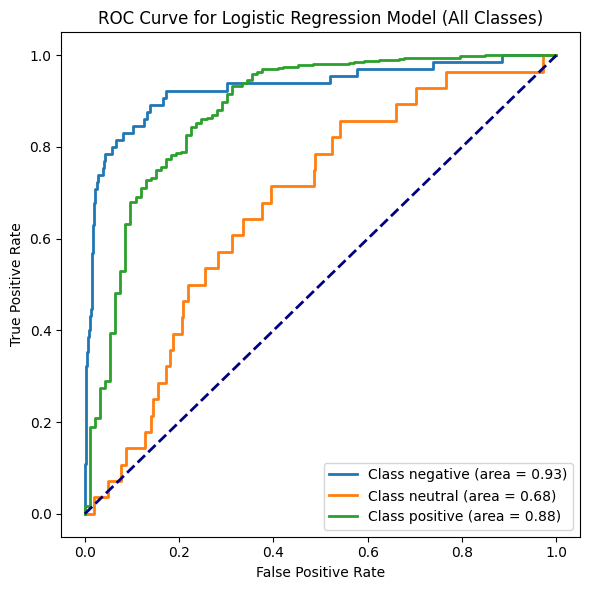

In [15]:
# Binarize the output labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(['negative', 'neutral', 'positive']):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], lr.predict_proba(X_test)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression Model (All Classes)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [16]:
# Generate classification report for Logistic Regression model
print('---------------------- Classification Report of Logistic Regression Model ----------------------')
print(classification_report(y_test, lr.predict(X_test),
                            labels=['negative', 'neutral', 'positive'],
                            target_names=['Negative', 'Neutral', 'Positive']))

---------------------- Classification Report of Logistic Regression Model ----------------------
              precision    recall  f1-score   support

    Negative       0.73      0.54      0.62        65
     Neutral       0.00      0.00      0.00        28
    Positive       0.94      0.98      0.96       890

    accuracy                           0.93       983
   macro avg       0.56      0.51      0.53       983
weighted avg       0.90      0.93      0.91       983



In [17]:
# Initialize Multinomial Naive Bayes model
nb = MultinomialNB()

# Train and evaluate the model
nb_accuracy, nb_precision, nb_recall, nb_f1, nb_auc_roc, _ = train_evaluate_model(nb, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Multinomial Naive Bayes Model')
print('-----------------------------')
print('Accuracy:', nb_accuracy)
print('Precision:', nb_precision)
print('Recall:', nb_recall)
print('F1 Score:', nb_f1)
print('AUC-ROC:', nb_auc_roc)

Multinomial Naive Bayes Model
-----------------------------
Accuracy: 0.9298067141403866
Precision: 0.5388888888888889
Recall: 0.5324690290982427
F1 Score: 0.5352486187845303
AUC-ROC: 0.6796425962915796


---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------


<Figure size 800x600 with 0 Axes>

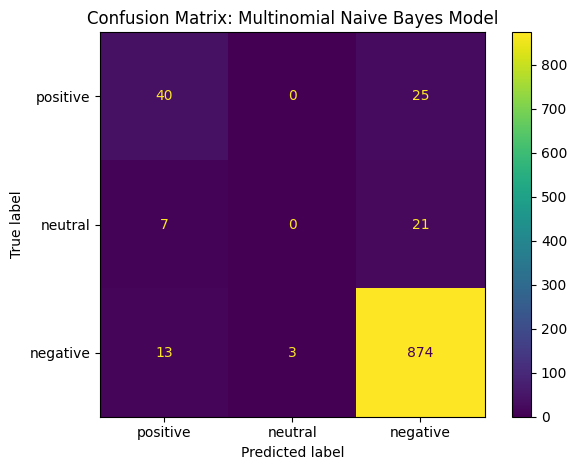

In [18]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, nb.predict(X_test))
print('---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------')

# Display the confusion matrix using labels
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
disp.plot(values_format='d')
plt.title('Confusion Matrix: Multinomial Naive Bayes Model')
plt.grid(False)
plt.tight_layout()
plt.show()

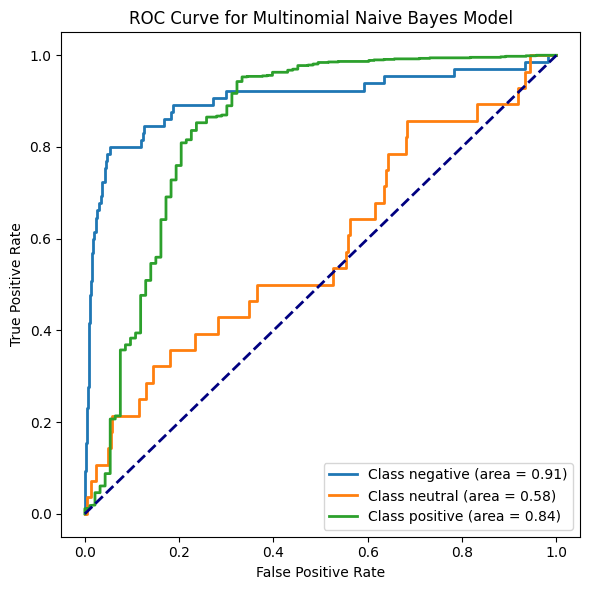

In [19]:
# Plot the ROC curve for each class
from sklearn.preprocessing import label_binarize

# Binarize the output labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(6, 6))
for i, class_label in enumerate(['negative', 'neutral', 'positive']):
	fpr, tpr, _ = roc_curve(y_test_binarized[:, i], nb.predict_proba(X_test)[:, i])
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multinomial Naive Bayes Model')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [20]:
# Classification report for Multinomial Naive Bayes model
print('---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------')
print(classification_report(y_test, nb.predict(X_test), target_names=['Negative', 'Neutral', 'Positive']))

---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------
              precision    recall  f1-score   support

    Negative       0.67      0.62      0.64        65
     Neutral       0.00      0.00      0.00        28
    Positive       0.95      0.98      0.97       890

    accuracy                           0.93       983
   macro avg       0.54      0.53      0.54       983
weighted avg       0.90      0.93      0.92       983



In [21]:
# Initialize Random Forest Classifier model
rf = RandomForestClassifier()

# Train and evaluate the model
rf_accuracy, rf_precision, rf_recall, rf_f1, rf_auc_roc, _ = train_evaluate_model(rf, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Random Forest Classifier Model')
print('-----------------------------')
print('Accuracy:', rf_accuracy)
print('Precision:', rf_precision)
print('Recall:', rf_recall)
print('F1 Score:', rf_f1)
print('AUC-ROC:', rf_auc_roc)

Random Forest Classifier Model
-----------------------------
Accuracy: 0.9114954221770092
Precision: 0.5955982905982906
Recall: 0.3688562373955632
F1 Score: 0.3817106761173748
AUC-ROC: 0.5287449866060892


---------------------- Confusion Matrix for Random Forest Classifier Model ----------------------


<Figure size 800x600 with 0 Axes>

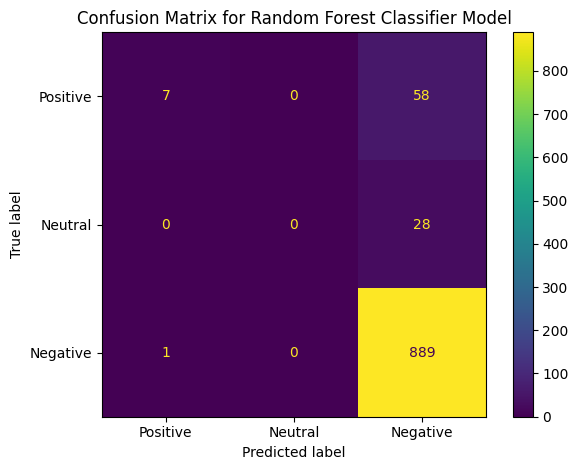

In [22]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, rf.predict(X_test))
print('---------------------- Confusion Matrix for Random Forest Classifier Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Positive', 'Neutral', 'Negative']).plot(values_format='d')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.tight_layout()
plt.grid(False)
plt.show()

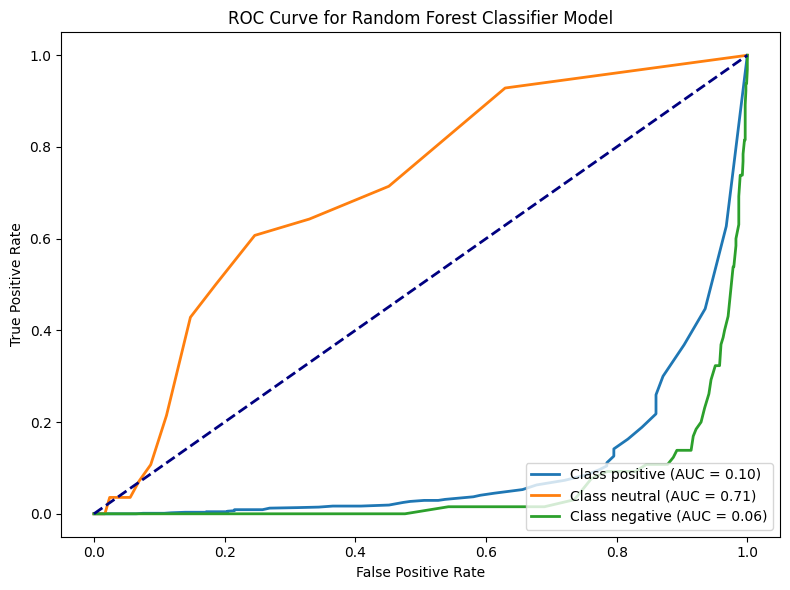

In [23]:
# Plot ROC curves for each class manually
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the true labels using the known order of classes
y_test_binarized = label_binarize(y_test, classes=labels_order)
n_classes = y_test_binarized.shape[1]

plt.figure(figsize=(8, 6))
for i, class_label in enumerate(labels_order):
	fpr, tpr, _ = roc_curve(y_test_binarized[:, i], rf.predict_proba(X_test)[:, i])
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve for Random Forest Classifier Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [24]:
# Classification report for Random Forest Classifier model
print('---------------------- Classification Report of Random Forest Classifier Model ----------------------')
print(classification_report(y_test, rf.predict(X_test), target_names=['Negative', 'Neutral', 'Positive']))

---------------------- Classification Report of Random Forest Classifier Model ----------------------
              precision    recall  f1-score   support

    Negative       0.88      0.11      0.19        65
     Neutral       0.00      0.00      0.00        28
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.60      0.37      0.38       983
weighted avg       0.88      0.91      0.88       983



In [25]:
# Initialize Linear Support Vector Classifier model
svc = LinearSVC()

# Train and evaluate the model
svc_accuracy, svc_precision, svc_recall, svc_f1, svc_auc_roc, svc_y_pred = train_evaluate_model(svc, X_train, y_train, X_test, y_test)

# Display the evaluation metrics
print('Linear Support Vector Classifier Model')
print('--------------------------------------')
print('Accuracy:', svc_accuracy)
print('Precision:', svc_precision)
print('Recall:', svc_recall)
print('F1 Score:', svc_f1)
print('AUC-ROC:', svc_auc_roc)

Linear Support Vector Classifier Model
--------------------------------------
Accuracy: 0.9186164801627671
Precision: 0.5728404527199707
Recall: 0.520864715808536
F1 Score: 0.5427916033663701
AUC-ROC: 0.6703453284531937


---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------


<Figure size 800x600 with 0 Axes>

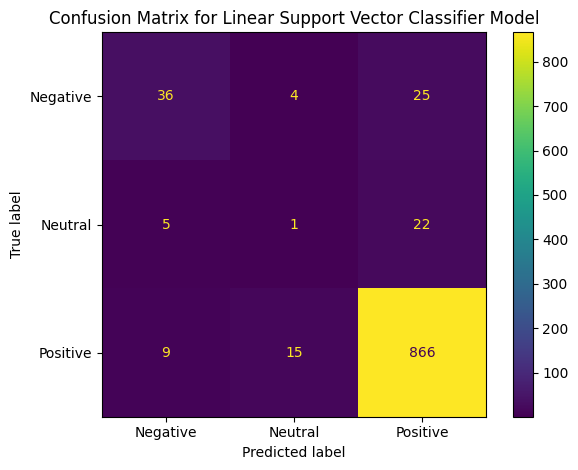

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test, svc.predict(X_test))
print('---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.grid(False)
plt.show()

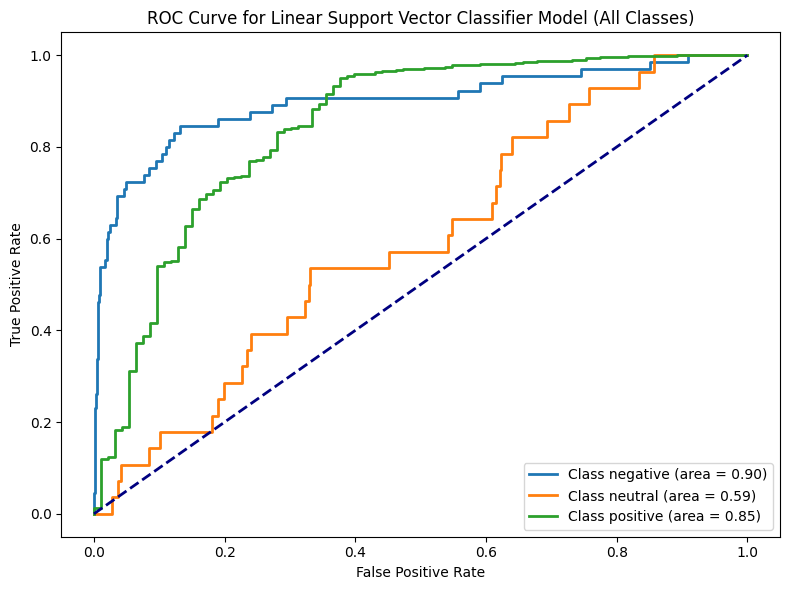

In [27]:
# Plot ROC curve for each class manually
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output labels for multi-class ROC curve
y_test_binarized = label_binarize(y_test, classes=['negative', 'neutral', 'positive'])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
plt.figure(figsize=(8, 6))
for i, class_label in enumerate(['negative', 'neutral', 'positive']):
	fpr, tpr, _ = roc_curve(y_test_binarized[:, i], svc.decision_function(X_test)[:, i])
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=2, label=f'Class {class_label} (area = {roc_auc:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Linear Support Vector Classifier Model (All Classes)')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [28]:
# Classification report for Linear Support Vector Classifier model
print('---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------')
print(classification_report(y_test, svc.predict(X_test),
                            labels=['positive', 'neutral', 'negative'],
                            target_names=['Positive', 'Neutral', 'Negative']))

---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------
              precision    recall  f1-score   support

    Positive       0.95      0.97      0.96       890
     Neutral       0.05      0.04      0.04        28
    Negative       0.72      0.55      0.63        65

    accuracy                           0.92       983
   macro avg       0.57      0.52      0.54       983
weighted avg       0.91      0.92      0.91       983



In [29]:
X_train_lstm = np.array(X_train)
X_test_lstm = np.array(X_test)
y_train_lstm = np.array(y_train)
y_test_lstm = np.array(y_test)
# Reshape the input data to be 3D [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0],
                                    X_train_lstm.shape[1], 1)
X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0],
                                  X_test_lstm.shape[1], 1)

# Encode string labels into numerical values
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the number of classes
num_classes = len(np.unique(y_train_encoded))
# Convert the labels to categorical format
y_train_lstm = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_lstm = to_categorical(y_test_encoded, num_classes=num_classes)


# Define the LSTM model architecture
model = Sequential()
model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], 1), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5000, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,483 (501.89 KB)

 Trainable params: 128,483 (501.89 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Train the model
history = model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=64, validation_data=(X_test_lstm, y_test_lstm))
# Evaluate the model
loss, accuracy = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate Metrics for LSTM using MSE, RMSE, MAE, and R2 Score
lstm_mse = np.mean((y_test_lstm - model.predict(X_test_lstm))**2)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mae = np.mean(np.abs(y_test_lstm - model.predict(X_test_lstm)))
lstm_r2 = 1 - (np.sum((y_test_lstm - model.predict(X_test_lstm))**2) / np.sum((y_test_lstm - np.mean(y_test_lstm))**2))
print(f"LSTM MSE: {lstm_mse:.4f}")
print(f"LSTM RMSE: {lstm_rmse:.4f}")
print(f"LSTM MAE: {lstm_mae:.4f}")
print(f"LSTM R2 Score: {lstm_r2:.4f}")

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 35s 488ms/step - accuracy: 0.8487 - loss: 0.6252 - val_accuracy: 0.9054 - val_loss: 0.3737
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 28s 439ms/step - accuracy: 0.9086 - loss: 0.3915 - val_accuracy: 0.9054 - val_loss: 0.3713
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 43s 485ms/step - accuracy: 0.9119 - loss: 0.3750 - val_accuracy: 0.9054 - val_loss: 0.3735
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 39s 455ms/step - accuracy: 0.9008 - loss: 0.4064 - val_accuracy: 0.9054 - val_loss: 0.3710
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 443ms/step - accuracy: 0.8990 - loss: 0.4161 - val_accuracy: 0.9054 - val_loss: 0.3724
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 444ms/step - accuracy: 0.9088 - loss: 0.3852 - val_accuracy: 0.9054 - val_loss: 0.3714
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 445ms/step - accuracy: 0.9054 - loss: 0.3884 - val_accuracy: 0.9054 - val_loss: 0.3711
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 31s 494ms/step - accuracy: 0.9018 - loss: 0.4044 - val_accu

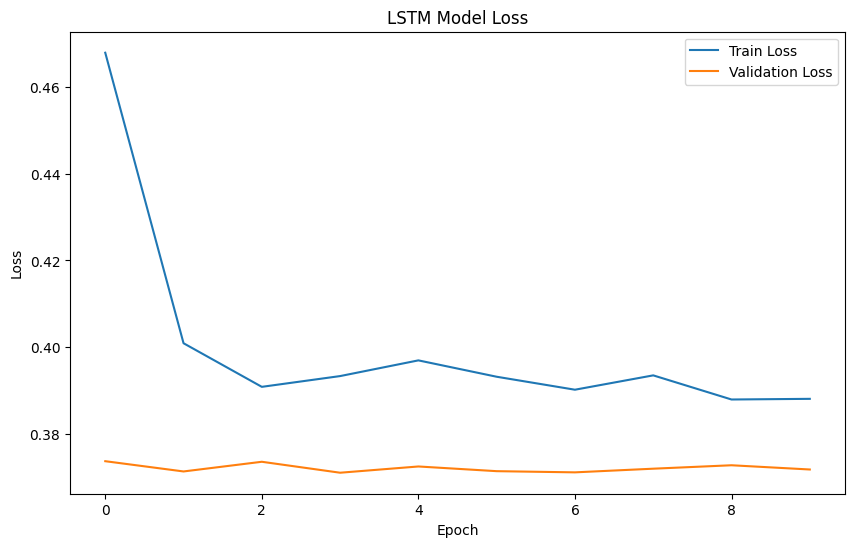

In [31]:
# Plot LSTM validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [32]:
# Print classification report of LSTM model
y_pred_lstm = np.argmax(model.predict(X_test_lstm), axis=-1)
y_test_lstm_labels = np.argmax(y_test_lstm, axis=-1)
print(classification_report(y_test_lstm_labels, y_pred_lstm, target_names=['Negative', 'Neutral', 'Positive']))

31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        65
     Neutral       0.00      0.00      0.00        28
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.30      0.33      0.32       983
weighted avg       0.82      0.91      0.86       983



<Figure size 800x600 with 0 Axes>

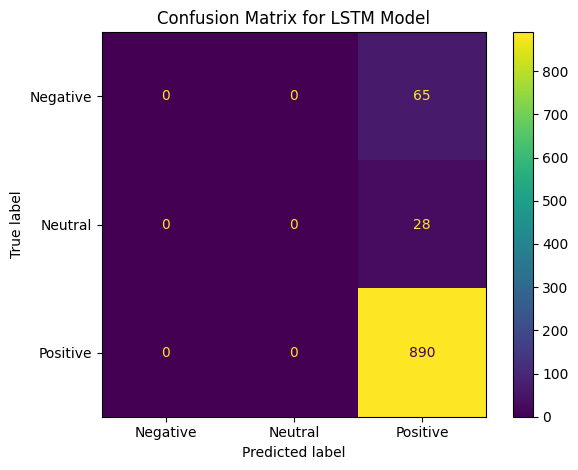

In [33]:
# Confusion Matrix LSTM
cm = confusion_matrix(y_test_lstm_labels, y_pred_lstm)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for LSTM Model')
plt.tight_layout()
plt.grid(False)
plt.show()

In [34]:
X_train_gru = np.array(X_train)
X_test_gru = np.array(X_test)
y_train_gru = np.array(y_train)
y_test_gru = np.array(y_test)

# Reshape the input data
X_train_gru = X_train_gru.reshape(X_train_gru.shape[0],
                                  X_train_gru.shape[1], 1)
X_test_gru = X_test_gru.reshape(X_test_gru.shape[0],
                                X_test_gru.shape[1], 1)

# Encode string in categorical
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the num_classes
num_classes = len(np.unique(y_train_encoded))
# Convert the labels to categorical format
y_train_gru = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_gru = to_categorical(y_test_encoded, num_classes=num_classes)

# Define GRU model architecture
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(X_train_gru.shape[1], 1),
                  return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(64, return_sequences=True))
gru_model.add(Dropout(0.5))
gru_model.add(GRU(32, return_sequences=False))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(num_classes, activation='softmax'))

gru_model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

gru_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5000, 128)      │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5000, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 5000, 64)       │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5000, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,059 (379.14 KB)

 Trainable params: 97,059 (379.14 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
gru_history = gru_model.fit(X_train_gru, y_train_gru, epochs=10,
                        batch_size=64,
                        validation_data=(X_test_gru, y_test_gru))

# Evaluate the model
loss, accuracy = gru_model.evaluate(X_test_gru, y_test_gru, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluation Metrics
gru_mse = np.mean((y_test_gru - gru_model.predict(X_test_gru))**2)
gru_rmse = np.sqrt(gru_mse)
gru_mae = np.mean(np.abs(y_test_gru - gru_model.predict(X_test_gru)))
gru_r2 = 1 - (np.sum((y_test_gru - gru_model.predict(X_test_gru))**2) / np.sum((y_test_gru - np.mean(y_test_gru))**2))

print(f"GRU Model")
print("===========")
print(f"GRU MSE: {gru_mse:.4f}")
print(f"GRU RMSE: {gru_rmse:.4f}")
print(f"GRU MAE: {gru_mae:.4f}")
print(f"GRU R2 Score: {gru_r2:.4f}")

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 441ms/step - accuracy: 0.8391 - loss: 0.6434 - val_accuracy: 0.9054 - val_loss: 0.3718
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 40s 434ms/step - accuracy: 0.9019 - loss: 0.4113 - val_accuracy: 0.9054 - val_loss: 0.3716
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 436ms/step - accuracy: 0.9100 - loss: 0.3820 - val_accuracy: 0.9054 - val_loss: 0.3786
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 0.9024 - loss: 0.4060 - val_accuracy: 0.9054 - val_loss: 0.3711
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 434ms/step - accuracy: 0.9062 - loss: 0.3932 - val_accuracy: 0.9054 - val_loss: 0.3718
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 41s 435ms/step - accuracy: 0.9000 - loss: 0.4010 - val_accuracy: 0.9054 - val_loss: 0.3728
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 27s 437ms/step - accuracy: 0.9058 - loss: 0.3850 - val_accuracy: 0.9054 - val_loss: 0.3723
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 42s 444ms/step - accuracy: 0.9056 - loss: 0.3795 - val_accu

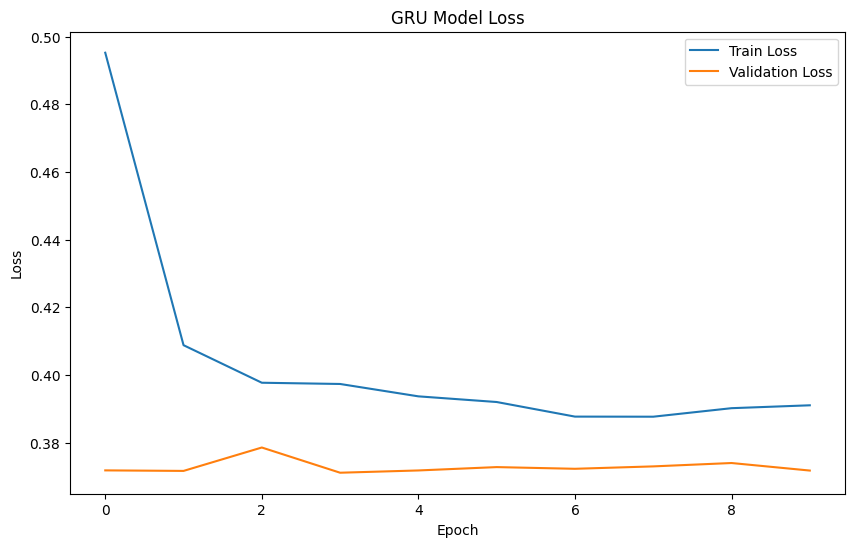

In [36]:
# Plot validation loss of GRU
plt.figure(figsize=(10, 6))
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('GRU Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [37]:
# Print classification report of GRU
y_pred_gru = np.argmax(gru_model.predict(X_test_gru), axis=-1)
y_test_gru_labels = np.argmax(y_test_gru, axis=-1)
print(classification_report(y_test_gru_labels, y_pred_gru,
                            target_names=['Negative',
                                          'Neutral',
                                          'Positive']))

31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        65
     Neutral       0.00      0.00      0.00        28
    Positive       0.91      1.00      0.95       890

    accuracy                           0.91       983
   macro avg       0.30      0.33      0.32       983
weighted avg       0.82      0.91      0.86       983



<Figure size 800x600 with 0 Axes>

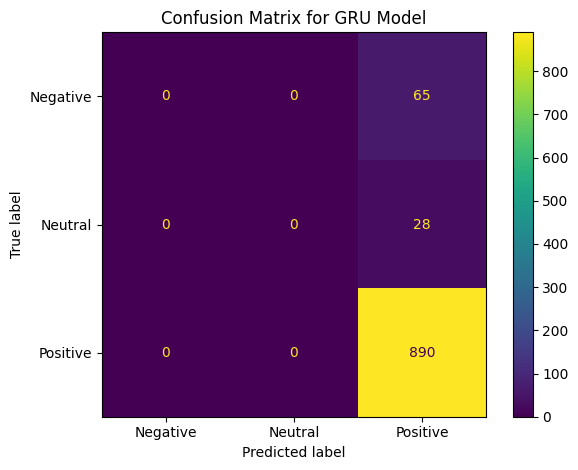

In [38]:
# Confusion Matrix on GRU Model
cm = confusion_matrix(y_test_gru_labels, y_pred_gru)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Neutral', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for GRU Model')
plt.tight_layout()
plt.grid(False)
plt.show()

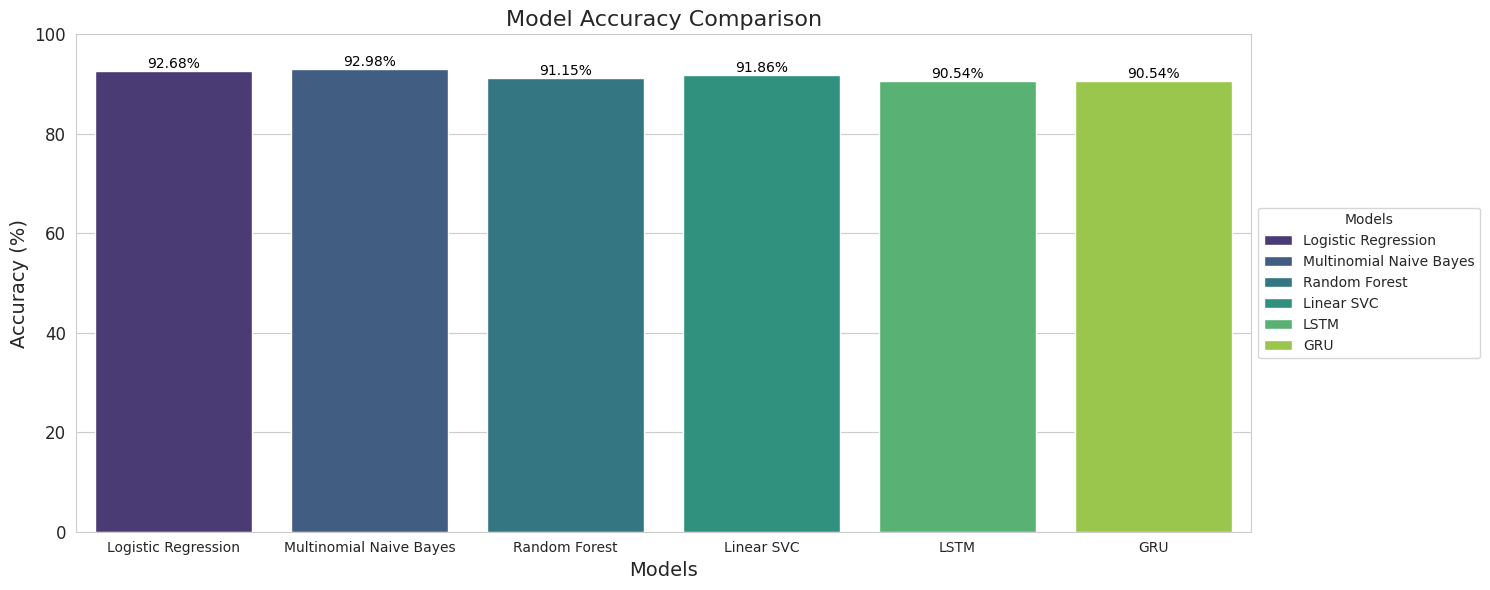

In [71]:
model_accuracies = {
    'Logistic Regression': lr_accuracy,
    'Multinomial Naive Bayes': nb_accuracy,
    'Random Forest': rf_accuracy,
    'Linear SVC': svc_accuracy,
    'LSTM': accuracy,
    'GRU': accuracy
}

# Convert the dictionary to a DataFrame for easier plotting
accuracy_df = pd.DataFrame({'Model': list(model_accuracies.keys()),
                            'Accuracy': list(model_accuracies.values())})

# Calculate percentage for each model's accuracy
accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

# Create the figure and axes object
plt.figure(figsize=(15, 6))
sns.set_style("whitegrid")

# Create the bar plot with assigned colors
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df,
                 palette='viridis', dodge=False)

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(fontsize=10, ha='center')
plt.yticks(fontsize=12)
plt.ylim(0, 100)

# Add percentage labels on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%',
     (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5),
                textcoords='offset points')


# Get the handles and labels for the legend
handles = ax.patches  # Get the bar objects directly
labels = accuracy_df['Model'].tolist()  # Get model names for labels

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models',
           loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# Twitter Sentiment Analysis

In [16]:
# Loading the data in .txt
test = pd.read_table('test_62k.txt')
train = pd.read_table('train_150k.txt')

train.head()

,0,Starting back at work today Looks like it'll be raining for the next couple of days
0,1,Sugar levels dropping... munchies setting in. ...
1,1,@karineb22 yeah!!! have a great summer break!
2,1,hannah montana was very good. now going to re...
3,1,"@Mayra326 aww, have fun! I just had my 3D las..."
4,0,Worried about my cat. Took him to the vet and ...


In [17]:
test.head()

,1,"@justineville ...yeahhh. ) i'm 39 tweets from 1,600!"
0,0,@ApplesnFeathers aww. Poor baby! On your only ...
1,0,@joeymcintyre With my refunded $225 (Australia...
2,0,It's fine. Today sucks just because me those t...
3,0,"Im just chilling on psp and stuff, but sitting..."
4,0,@lisarinna very sad Lisa...she is freeeeeeeeee...


In [18]:
train.shape, test.shape

((149984, 2), (61997, 2))

In [19]:
# Rename columns for train and test DataFrames
train.columns = ['N', 'text']
test.columns = ['N', 'text']

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

Training Data:


,N,text
0,1,Sugar levels dropping... munchies setting in. ...
1,1,@karineb22 yeah!!! have a great summer break!
2,1,hannah montana was very good. now going to re...
3,1,"@Mayra326 aww, have fun! I just had my 3D las..."
4,0,Worried about my cat. Took him to the vet and ...


In [20]:
train['N'].value_counts()

,count
N,
0,75018
1,74966


In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149984 entries, 0 to 149983
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   N       149984 non-null  int64 
 1   text    149984 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [22]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,@ApplesnFeathers aww. Poor baby! On your only ...
1,0,@joeymcintyre With my refunded $225 (Australia...
2,0,It's fine. Today sucks just because me those t...
3,0,"Im just chilling on psp and stuff, but sitting..."
4,0,@lisarinna very sad Lisa...she is freeeeeeeeee...


In [23]:
test['N'].value_counts()

,count
N,
1,31028
0,30969


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61997 entries, 0 to 61996
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   N       61997 non-null  int64 
 1   text    61997 non-null  object
dtypes: int64(1), object(1)
memory usage: 968.8+ KB


In [25]:
# Preprocessing on text column of both train and test DataFrames using a define function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.strip()
    return text

# Apply the preprocess_text function to the 'text' column of both DataFrames
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

Training Data:


,N,text
0,1,sugar levels dropping munchies setting in luck...
1,1,karineb yeah have a great summer break
2,1,hannah montana was very good now going to rea...
3,1,mayra aww have fun i just had my d last week
4,0,worried about my cat took him to the vet and h...


In [26]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,applesnfeathers aww poor baby on your only rea...
1,0,joeymcintyre with my refunded australian tick...
2,0,its fine today sucks just because me those thi...
3,0,im just chilling on psp and stuff but sitting ...
4,0,lisarinna very sad lisashe is freeeeeeeeeeee a...


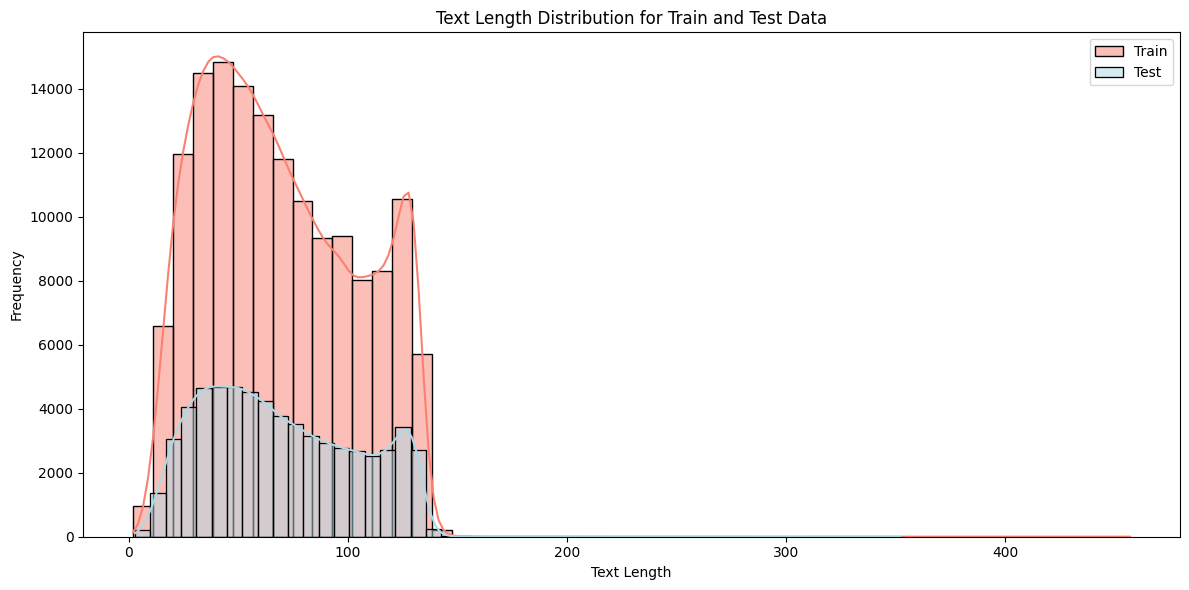

In [27]:
# Visualize the text length distribution for both train and test DataFrames
plt.figure(figsize=(12, 6))
sns.histplot(train['text'].apply(len), color='salmon', bins=50, kde=True, label='Train')
sns.histplot(test['text'].apply(len), color='lightblue', bins=50, kde=True, label='Test')
plt.title('Text Length Distribution for Train and Test Data')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

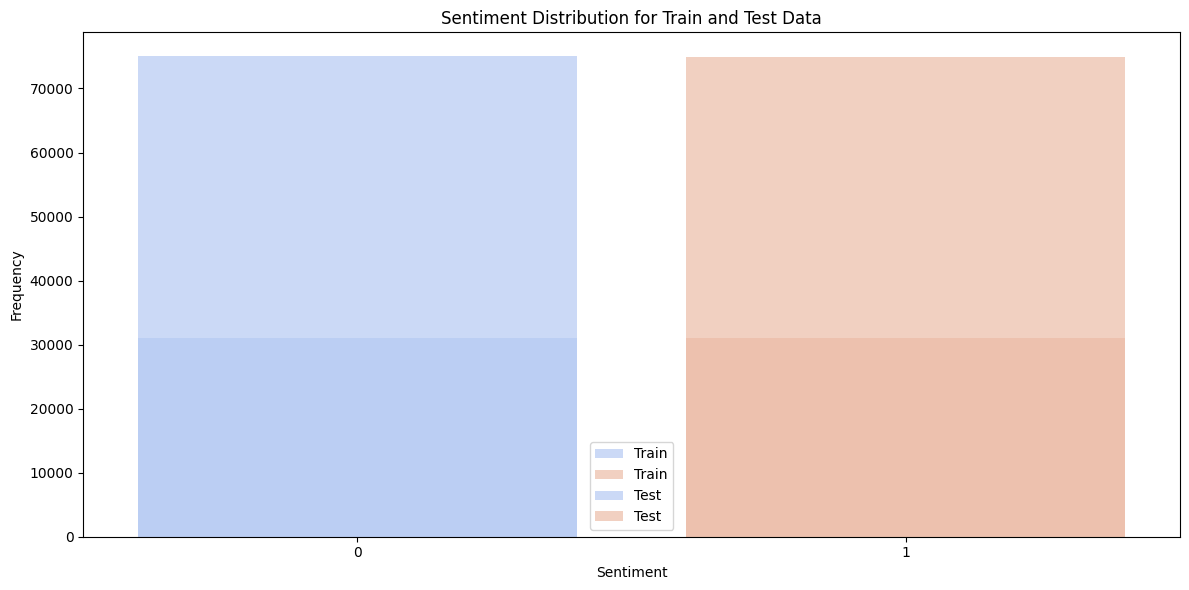

In [28]:
# Visualize the text column based on the sentiment for both train and test DataFrames
plt.figure(figsize=(12, 6))
sns.countplot(x='N', data=train, palette='coolwarm', label='Train', alpha=0.7)
sns.countplot(x='N', data=test, palette='coolwarm', label='Test', alpha=0.7)
plt.title('Sentiment Distribution for Train and Test Data')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

# Define function to remove punctuation, numbers, stopwords, then tokenize, stem, and lemmatize in lower column for both train and test DataFrames
def preprocess_text(text):
    # Removing Punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Removing Numbers
    text = re.sub(r'\d+', '', text)

    # Removing Stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in (stop_words)])

    # Tokenization
    text = word_tokenize(text)

    # Stemming
    stemmer = nltk.PorterStemmer()
    text = [stemmer.stem(y) for y in text]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    text = [lemmatizer.lemmatize(y) for y in text]

    return text

# Apply the preprocess_text function to the 'text' column of both DataFrames
train['text'] = train['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

# Display the first few rows to verify the changes
print("Training Data:")
train.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Training Data:


,N,text
0,1,"[sugar, level, drop, munchi, set, luckili, bla..."
1,1,"[karineb, yeah, great, summer, break]"
2,1,"[hannah, montana, good, go, read, twilight]"
3,1,"[mayra, aww, fun, last, week]"
4,0,"[worri, cat, took, vet, blood, work, etc, norm..."


In [30]:
print("\nTest Data:")
test.head()


Test Data:


,N,text
0,0,"[applesnfeath, aww, poor, babi, real, day]"
1,0,"[joeymcintyr, refund, australian, ticket, pric..."
2,0,"[fine, today, suck, thing, dunno, see]"
3,0,"[im, chill, psp, stuff, sit, pc, also, watch, ..."
4,0,"[lisarinna, sad, lisash, freeeeeeeeeeee, angel..."


In [ ]:
from sklearn.metrics import roc_auc_score

# Perform Word Embedding using CountVectorizer
cv = CountVectorizer(max_features=5000)
X_train = cv.fit_transform(train['text'].apply(lambda x: ' '.join(x))).toarray()
y_train = train['N']
X_test = cv.transform(test['text'].apply(lambda x: ' '.join(x))).toarray()
y_test = test['N']

# Initialize Linear Regression model
lr = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1, verbose=1, solver='liblinear', C=0.1)

# Train and evaluate the model
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Display the evaluation metrics
lr_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Logistic Regression Model')
print('-------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

[LibLinear]Logistic Regression Model
-------------------------
Accuracy: 0.7328419117054051
Precision: 0.7500987811920611
Recall: 0.7953783679257445
F1 Score: 0.7720752710037698
AUC-ROC: 0.7649435350881911


---------------------- Confusion Matrix for Logistic Regression Model ----------------------


<Figure size 800x600 with 0 Axes>

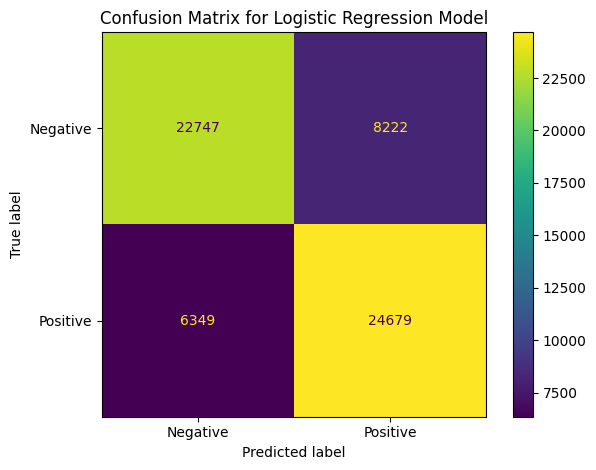

In [ ]:
# Calculate the confusion matrix for Logistic Regression model
cm = confusion_matrix(y_test, lr.predict(X_test))
print('---------------------- Confusion Matrix for Logistic Regression Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

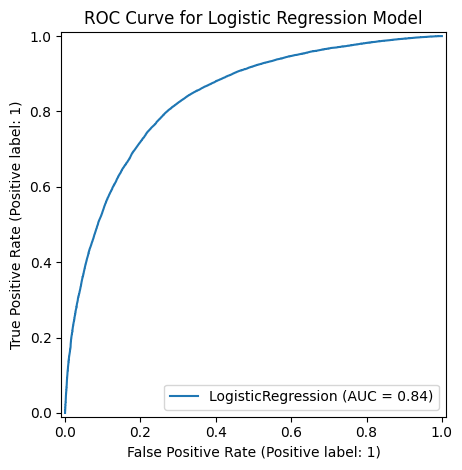

In [ ]:
# Plot the ROC curve for Logistic Regression model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(lr, X_test, y_test)

plt.title('ROC Curve for Logistic Regression Model')
plt.tight_layout()
plt.show()

In [ ]:
# Generate classification report for Logistic Regression model
print('---------------------- Classification Report of Logistic Regression Model ----------------------')
print(classification_report(y_test, lr.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Logistic Regression Model ----------------------
              precision    recall  f1-score   support

    Negative       0.78      0.73      0.76     30969
    Positive       0.75      0.80      0.77     31028

    accuracy                           0.76     61997
   macro avg       0.77      0.76      0.76     61997
weighted avg       0.77      0.76      0.76     61997

------------------------------------------------------------


In [47]:
# Initialize Multinomial Naive Bayes model
nb = MultinomialNB(alpha=0.1, fit_prior=True, class_prior=None)

# Train and evaluate the model
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)

# Display the evaluation metrics
mnb_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Multinomial Naive Bayes Model')
print('-----------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

Multinomial Naive Bayes Model
-----------------------------
Accuracy: 0.7328419117054051
Precision: 0.7606126625734468
Recall: 0.742619569421168
F1 Score: 0.7515084309057108
AUC-ROC: 0.7542249579483378


---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------


<Figure size 800x600 with 0 Axes>

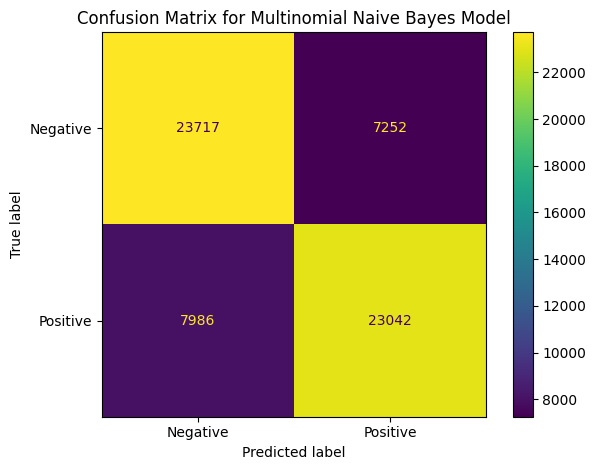

In [36]:
# Calculate the confusion matrix for Multinomial Naive Bayes model
cm = confusion_matrix(y_test, nb.predict(X_test))
print('---------------------- Confusion Matrix for Multinomial Naive Bayes Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

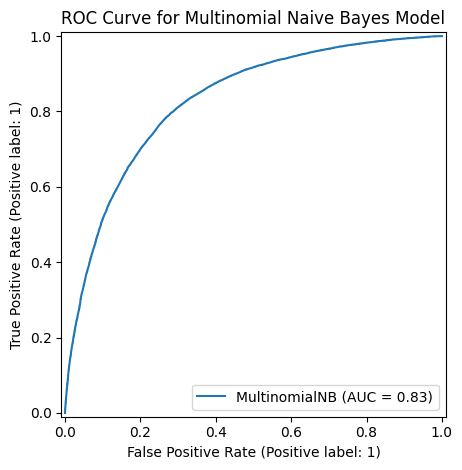

In [37]:
# Plot the ROC curve for Multinomial Naive Bayes model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(nb, X_test, y_test)

plt.title('ROC Curve for Multinomial Naive Bayes Model')
plt.tight_layout()
plt.show()

In [38]:
# Classification report for Multinomial Naive Bayes model
print('---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------')
print(classification_report(y_test, nb.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Multinomial Naive Bayes Model ----------------------
              precision    recall  f1-score   support

    Negative       0.75      0.77      0.76     30969
    Positive       0.76      0.74      0.75     31028

    accuracy                           0.75     61997
   macro avg       0.75      0.75      0.75     61997
weighted avg       0.75      0.75      0.75     61997

------------------------------------------------------------


In [48]:
# Initialize Support Vector Classifier model
svc = LinearSVC(max_iter=10000, random_state=42, C=1)

# Train and evaluate the model
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

# Display the evaluation metrics
svc_accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

# Display the evaluation metrics
print('Linear Support Vector Classifier Model')
print('--------------------------------------')
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('AUC-ROC:', auc_roc)

Linear Support Vector Classifier Model
--------------------------------------
Accuracy: 0.7328419117054051
Precision: 0.7457103013399624
Recall: 0.7927678226118344
F1 Score: 0.7685193863842285
AUC-ROC: 0.7609581629769431


---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------


<Figure size 800x600 with 0 Axes>

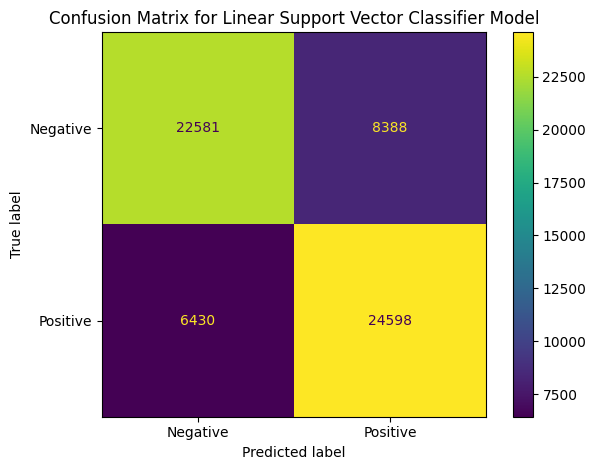

In [40]:
# Calculate the confusion matrix for Linear Support Vector Classifier model
cm = confusion_matrix(y_test, svc.predict(X_test))
print('---------------------- Confusion Matrix for Linear Support Vector Classifier Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))

ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.grid(False)
plt.show()

<Figure size 800x600 with 0 Axes>

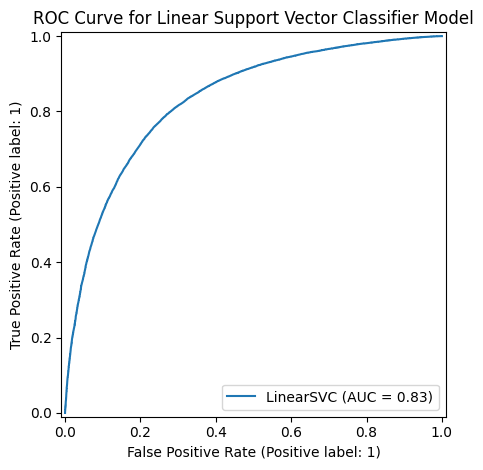

In [41]:
# Plot the ROC curve for Linear Support Vector Classifier model
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(svc, X_test, y_test)

plt.title('ROC Curve for Linear Support Vector Classifier Model')
plt.tight_layout()
plt.show()

In [42]:
# Classification report for Linear Support Vector Classifier model
print('---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------')
print(classification_report(y_test, svc.predict(X_test), target_names=['Negative', 'Positive']))
print('------------------------------------------------------------')

---------------------- Classification Report of Linear Support Vector Classifier Model ----------------------
              precision    recall  f1-score   support

    Negative       0.78      0.73      0.75     30969
    Positive       0.75      0.79      0.77     31028

    accuracy                           0.76     61997
   macro avg       0.76      0.76      0.76     61997
weighted avg       0.76      0.76      0.76     61997

------------------------------------------------------------


---------------------- Confusion Matrix for Multi-layer Perceptron Model ----------------------


<Figure size 800x600 with 0 Axes>

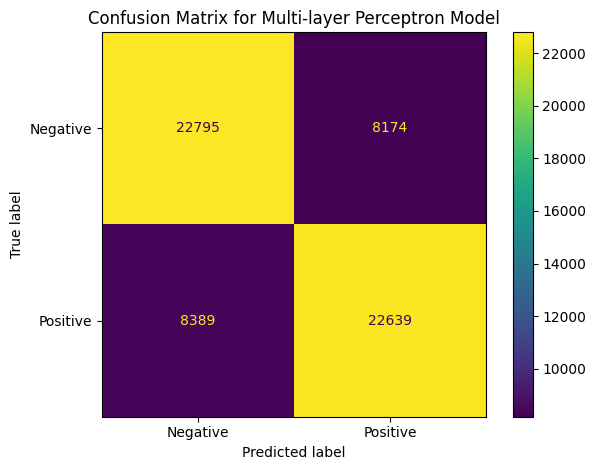

In [44]:
# Calculate the confusion matrix for Multi-layer Perceptron model
cm = confusion_matrix(y_test, mlp.predict(X_test))
print('---------------------- Confusion Matrix for Multi-layer Perceptron Model ----------------------')

# Display the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(cm, display_labels=['Negative', 'Positive']).plot(values_format='d')
plt.title('Confusion Matrix for Multi-layer Perceptron Model')
plt.tight_layout()
plt.grid(False)
plt.show()

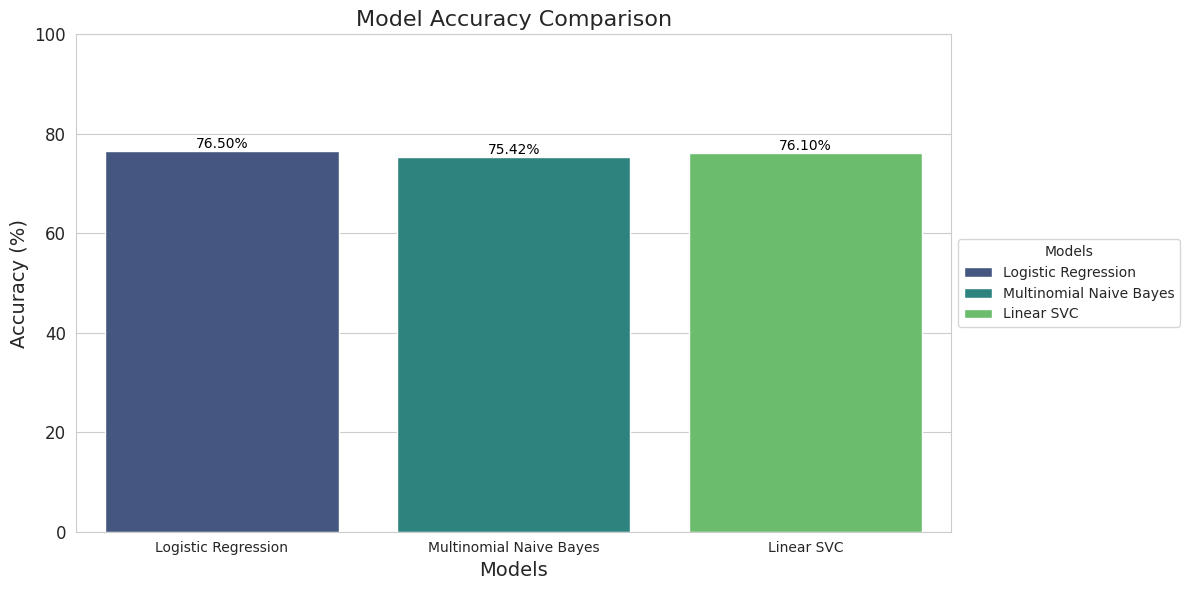

In [51]:
model_accuracies = {
    'Logistic Regression': lr_accuracy,
    'Multinomial Naive Bayes': mnb_accuracy,
    'Linear SVC': svc_accuracy
}

accuracy_df = pd.DataFrame({'Model': list(model_accuracies.keys()),
                            'Accuracy': list(model_accuracies.values())})

accuracy_df['Accuracy (%)'] = accuracy_df['Accuracy'] * 100

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
ax = sns.barplot(x='Model', y='Accuracy (%)', data=accuracy_df, palette='viridis')

plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy (%)', fontsize=14)
plt.xticks(ha='center', fontsize=10)
plt.yticks(fontsize=12)
plt.ylim(0, 100)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}%', (p.get_x() + p.get_width() / 2.,
                                           p.get_height()),
                ha='center', va='center', fontsize=10, color='black',
                xytext=(0, 5), textcoords='offset points')

handles = ax.patches
labels = accuracy_df['Model'].tolist()

# Create a new legend outside the plot
plt.legend(handles, labels, title='Models', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()